# Homework 2: Data from the Web

In this homework, we are going to fetch information from the EPFL website IS-Academia. The idea is to read data from the webpage in an html format, to parse this data using external library BeautifulSoup and to analyze the data obtained extracting some statistical information.
We can then decompose the work in two principal activities: 
- Fetching the data
- Analyzing the data

# Fetching data from IS-Academia

We import first the libraries we'll need in this notebook

In [1]:
#Usual imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

#Specific imports for data fetching
import requests #HTTP requests
from bs4 import BeautifulSoup as BSoup #HTML parsing

Let's start by indexing the web page where we are going to fetch all the data, i.e IS-Academia

In [2]:
# URL containing the empty form of IS_Academia that list students
main_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_x_GPS=-1&ww_i_reportModel=133685247'

# URL containing the form with the fields that we will replace depending on the information we want to extract, i.e {ACADEMIC_PERIOD_KEY}
form_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD={ACADEMIC_UNIT_KEY}&ww_x_PERIODE_ACAD={ACADEMIC_PERIOD_KEY}&ww_x_PERIODE_PEDAGO={PEDAGOGIC_PERIOD_KEY}&ww_x_HIVERETE={HIVERETE_KEY}'

The webpage where the data are stored is in a form format. Therefore, we have to change the URL depending on which list of student we want. We can check which are the specific keys for each section, year, bachelor semester and season, in order to obtain the corresponding student list when we replace them in the "form_url" above. The field (or parameters) to be change in the URL are given in brackets { }, for example {ACADEMIC_UNIT_KEY}.

In [3]:
# We get the raw data of the main page
ugly_html = requests.get(main_url)
    
# We parse it using BeautifulSoup
beautiful_html = BSoup(ugly_html.text, 'html.parser')

section_keys = {}
year_keys = {}
semester_keys = {}
season_keys = {}

# We store all the keys of the sections
unite_html = beautiful_html.find('select', {'name': 'ww_x_UNITE_ACAD'})
for unite in unite_html.find_all('option'):
    section_keys[unite.text] = unite.get('value')

# We store all the keys of the academic years
acad_period_html = beautiful_html.find('select', {'name': 'ww_x_PERIODE_ACAD'})
for period in acad_period_html.find_all('option'):
    year_keys[period.text] = period.get('value')

# We store all the keys of the academic semester (Bachelor and Master)
peda_period_html = beautiful_html.find('select', {'name': 'ww_x_PERIODE_PEDAGO'})
for peda in peda_period_html.find_all('option'):
    semester_keys[peda.text] = peda.get('value')

# We store all the keys of the seasons (Autumn / Spring)
season_html = beautiful_html.find('select', {'name': 'ww_x_HIVERETE'})
for season in season_html.find_all('option'):
    season_keys[season.text] = season.get('value')
    

We can verify that we have all the keys that we need:

(Note that the first entry is empty. It represents the situation when the user does not precise what he wants for this field of research)

In [4]:
section_keys

{'': 'null',
 'Architecture': '942293',
 'Chimie et génie chimique': '246696',
 'Cours de mathématiques spéciales': '943282',
 'EME (EPFL Middle East)': '637841336',
 'Génie civil': '942623',
 'Génie mécanique': '944263',
 'Génie électrique et électronique ': '943936',
 'Humanités digitales': '2054839157',
 'Informatique': '249847',
 'Ingénierie financière': '120623110',
 'Management de la technologie': '946882',
 'Mathématiques': '944590',
 'Microtechnique': '945244',
 'Physique': '945571',
 'Science et génie des matériaux': '944917',
 "Sciences et ingénierie de l'environnement": '942953',
 'Sciences et technologies du vivant': '945901',
 'Section FCUE': '1574548993',
 'Systèmes de communication': '946228'}

In [5]:
year_keys

{'': 'null',
 '2007-2008': '978181',
 '2008-2009': '978187',
 '2009-2010': '978195',
 '2010-2011': '39486325',
 '2011-2012': '123455150',
 '2012-2013': '123456101',
 '2013-2014': '213637754',
 '2014-2015': '213637922',
 '2015-2016': '213638028',
 '2016-2017': '355925344'}

In [6]:
semester_keys

{'': 'null',
 'Bachelor semestre 1': '249108',
 'Bachelor semestre 2': '249114',
 'Bachelor semestre 3': '942155',
 'Bachelor semestre 4': '942163',
 'Bachelor semestre 5': '942120',
 'Bachelor semestre 5b': '2226768',
 'Bachelor semestre 6': '942175',
 'Bachelor semestre 6b': '2226785',
 'Master semestre 1': '2230106',
 'Master semestre 2': '942192',
 'Master semestre 3': '2230128',
 'Master semestre 4': '2230140',
 'Mineur semestre 1': '2335667',
 'Mineur semestre 2': '2335676',
 'Mise à niveau': '2063602308',
 'Projet Master automne': '249127',
 'Projet Master printemps': '3781783',
 'Semestre automne': '953159',
 'Semestre printemps': '2754553',
 'Stage automne 3ème année': '953137',
 'Stage automne 4ème année': '2226616',
 'Stage printemps 3ème année': '983606',
 'Stage printemps 4ème année': '2226626',
 'Stage printemps master': '2227132'}

In [7]:
season_keys

{'': 'null',
 "Semestre d'automne": '2936286',
 'Semestre de printemps': '2936295'}

We create a function that update the URL depending on the list of student we want, for example 'Informatique / 2007-2008 / Bachelor semestre 1 / Semestre d'automne'.

In [8]:
def getSpecificURL(section, years, semester, season):
    new_url = form_url;
    new_url = new_url.replace('{ACADEMIC_UNIT_KEY}', str(section_keys[section]))
    new_url = new_url.replace('{ACADEMIC_PERIOD_KEY}', str(year_keys[years]))
    new_url = new_url.replace('{PEDAGOGIC_PERIOD_KEY}', str(semester_keys[semester]))
    new_url = new_url.replace('{HIVERETE_KEY}', str(season_keys[season]))
    return new_url

In [9]:
getSpecificURL('Informatique', '2007-2008', 'Bachelor semestre 1', 'Semestre d\'automne')

'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=978181&ww_x_PERIODE_PEDAGO=249108&ww_x_HIVERETE=2936286'

If you tap this URL in your favorite browser, you will obtain the list of student for this specific year and semester.

Before extracting the data we want, we still have to define a function that parse correctly the list of student (given in html) into a well designed DataFrame. To do so, we define the function parseTable:

In [10]:
def parseTable(table):
    # Search on all the lines
    lines = table.find_all('tr')
    N = len(lines)
    output = []
    
    
    for i in range(2, N-1):
        # Search on all the columns
        line = lines[i]
        rows = line.find_all('td')
        M = len(rows)
        if M > 0:
            gender = rows[0].text
            name = rows[1].text
            sciper = rows[10].text
            status = rows[7].text
            output.append({'gender':gender, 'name':name, 'sciper':sciper, 'status':status})
            
    return pd.DataFrame(output)

Now that we have all the tools that we needed to extract the data correctly, we can start fetching them from IS-Academia. First, we have to decide which ones are interesting for us. We will focus only on the *'Informatique'* section and on the students that have finished their bachelor degree. We will then store only the information on *'Informatique'* students that have *'Bachelor semestre 1'*, *'Bachelor semestre 5'* and *'Bachelor semestre 6'* entries. We  have to keep the *'Bachelor semestre 5'* entries because a student can finish his degree in the semester 5 if he redoes only half a year.

Note also that we don't take into account the academic year 2016-2017, because the students have not completed there cursus yet.

In [11]:
spec_section = ['Informatique']
spec_year = ['2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016']
spec_semester = ['Bachelor semestre 1','Bachelor semestre 5','Bachelor semestre 6']
spec_season = ['Semestre d\'automne', 'Semestre de printemps']

In [12]:
all_data = []

for section in spec_section:
    for year in spec_year:
        for semester in spec_semester:
            for season in spec_season:
                spec_url = getSpecificURL(section, year, semester, season)
                spec_html = requests.get(spec_url)
                spec_beautiful_html = BSoup(spec_html.text, 'html.parser')
                
                student_table = spec_beautiful_html.find('table')
                student_data = parseTable(student_table)
                student_data['section'] = section
                student_data['year'] = year
                student_data['semester'] = semester
                student_data['season'] = season
                
                if not(student_data.empty):
                    all_data.append(student_data)

In [13]:
all_data[0].head(10)

,gender,name,sciper,status,section,year,semester,season
0,Monsieur,Arévalo Christian,169569,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
1,Monsieur,Aubelle Flavien,174905,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
2,Monsieur,Badoud Morgan,173922,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
3,Monsieur,Baeriswyl Jonathan,179406,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
4,Monsieur,Barroco Michael,179428,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
5,Monsieur,Belfis Nicolas,179324,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
6,Monsieur,Beliaev Stanislav,174597,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
7,Monsieur,Bindschaedler Vincent,179449,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
8,Monsieur,Bloch Marc-Olivier,178553,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
9,Monsieur,Bloch Remi,179426,Présent,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne


In [14]:
all_data_frame = pd.concat(all_data)
all_data_frame.shape

(2868, 8)

In oder to avoid unecessary future process, we store all the data in a csv file

In [15]:
all_data_frame.to_csv('data_ba.csv', ',', index=False)

For futher work, we will also need the students in master degree. Therefore, we can redo the process above and store these new datas in another file. However, the data has a different structure for the master students. For example, it would be interesting to store the minor the student has (if he has one) etc...

We need then to redefine a parser for the list of master students.

In [16]:
def parseTable_ma(table):
    # Search on all the lines
    lines = table.find_all('tr')
    N = len(lines)
    output = []
    
    
    for i in range(2, N-1):
        # Search on all the columns
        line = lines[i]
        rows = line.find_all('td')
        M = len(rows)
        if M > 0:
            gender = rows[0].text
            name = rows[1].text
            sciper = rows[10].text
            status = rows[7].text
            special = rows[4].text
            minor = rows[6].text
            output.append({'gender':gender, 'name':name, 'sciper':sciper, 'status':status, 'specialization': special, 'minor':minor})
            
    return pd.DataFrame(output)

In [17]:
spec_semester_ma = ['Master semestre 1','Master semestre 2','Master semestre 3','Master semestre 4']

In [18]:
all_data_ma = []

for section in spec_section:
    for year in spec_year:
        for semester in spec_semester_ma:
            for season in spec_season:
                spec_url = getSpecificURL(section, year, semester, season)
                spec_html = requests.get(spec_url)
                spec_beautiful_html = BSoup(spec_html.text, 'html.parser')
                
                student_table = spec_beautiful_html.find('table')
                student_data = parseTable_ma(student_table)
                student_data['section'] = section
                student_data['year'] = year
                student_data['semester'] = semester
                student_data['season'] = season
                
                if not(student_data.empty):
                    all_data_ma.append(student_data)

In [19]:
all_data_frame_ma = pd.concat(all_data_ma)
all_data_frame_ma.shape

(2431, 10)

In [20]:
all_data_frame_ma.head(15)

,gender,minor,name,sciper,specialization,status,section,year,semester,season
0,Monsieur,,Aeberhard François-Xavier,153066,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
1,Madame,,Agarwal Megha,180027,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
2,Monsieur,,Anagnostaras David,152232,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
3,Monsieur,,Auroux Damien,177395,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
4,Monsieur,,Awalebo Joseph,161970,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
5,Monsieur,,Balet Ken,166258,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
6,Monsieur,,Barazzutti Raphaël Pierre,173600,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
7,Monsieur,,Bayramoglu Ersoy,178879,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
8,Madame,,Benabdallah Zeineb,154573,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
9,Monsieur,,Bettex Marc,160492,,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne


Again, we store these data in a csv file

In [21]:
all_data_frame_ma.to_csv('data_ma.csv', ',', index=False)

# Assignments: Analyzing the data

Now that we have fetched all the data interesting for us, we can start analyzing them and try to extract interesting information.

It is possible to import data without requesting the server because everything had been stored previously in memory.

In [22]:
all_data_frame = pd.read_csv('data_ba.csv', ',')
all_data_frame.shape

(2868, 8)

In [23]:
all_data_frame_ma = pd.read_csv('data_ma.csv', ',')
all_data_frame_ma.shape

(2431, 10)

## TASK 1: Bachelor students

In this first task, we will consider only the students that have finished their Bachelor degree and see how many months they took to complete it. We will then separate the students between men and women and observe if the time difference is statically interesting.

Note that we have to keep all the student with the status 'Congé', because they can finish their bachelor when they do an ERASMUS.

In [24]:
data = pd.read_csv('data_ba.csv', ',')

We sort the people by sciper and check if each student has an entry for *'Bachelor semester 6'*. If not, we remove the corresponding person. We can then check the years of the first and the last semester done at EPFL. With this methodolgy, we will consider as well the student that have finished their Bachelor degree after redoing only the *'Bachelor semester 5'*.

Note that we cannot know if a student actually graduated after the *'Bachelor semester 6'* or if he failed at the last step. Therefore, we will consider that all the students with a *'Bachelor semester 6'* entry did graduated at some point.

In [25]:
# Sort people
data.sort_values(ascending=[True, True, True], by=['sciper', 'year', 'semester'], inplace=True)

# Select only the people for which we have a 'Bachelor semester 1' entry
starting_scipers = data[data.semester == 'Bachelor semestre 1'].sciper.drop_duplicates(keep='first')

# Select only people that have completed their degree (i.e have a 'Bachelor semester 6' entry)
graduated_scipers = data[data.semester == 'Bachelor semestre 6'].sciper.drop_duplicates(keep='first')

# Take the intersection of the two list of scipers above
correct_scipers = pd.Series(list(set(starting_scipers).intersection(set(graduated_scipers)))).sort_values(ascending=True)

In [26]:
data_corrected = data[data['sciper'].isin(correct_scipers)]
data.head(12)

,gender,name,sciper,status,section,year,semester,season
204,Monsieur,Good Xavier,147008,Présent,Informatique,2008-2009,Bachelor semestre 1,Semestre d'automne
796,Monsieur,Good Xavier,147008,Congé,Informatique,2010-2011,Bachelor semestre 5,Semestre d'automne
853,Monsieur,Good Xavier,147008,Congé,Informatique,2010-2011,Bachelor semestre 6,Semestre de printemps
100,Monsieur,Conus Johann,153762,Présent,Informatique,2007-2008,Bachelor semestre 5,Semestre d'automne
144,Monsieur,Conus Johann,153762,Présent,Informatique,2007-2008,Bachelor semestre 6,Semestre de printemps
89,Madame,Andriambololona Riana Miarantsoa,154157,Présent,Informatique,2007-2008,Bachelor semestre 5,Semestre d'automne
123,Monsieur,Raja Yanick,159516,Présent,Informatique,2007-2008,Bachelor semestre 5,Semestre d'automne
164,Monsieur,Raja Yanick,159516,Présent,Informatique,2007-2008,Bachelor semestre 6,Semestre de printemps
112,Madame,Jesse Julia,159998,Présent,Informatique,2007-2008,Bachelor semestre 5,Semestre d'automne
153,Madame,Jesse Julia,159998,Présent,Informatique,2007-2008,Bachelor semestre 6,Semestre de printemps


In [27]:
# Find starting semester of the Bachelor. We keep the first one if the student has redone his first year.
startData = data_corrected[data_corrected.semester == 'Bachelor semestre 1'].copy()
startData.drop_duplicates(subset=['sciper'], keep='first', inplace = True)

# Find ending semester of the Bachelor. We keep the last one if the student has redone some semesters.
endData = data_corrected[data_corrected['semester'].isin(['Bachelor semestre 6', 'Bachelor semestre 5'])].copy()
endData.drop_duplicates(subset=['sciper'], keep='last', inplace = True)

In [28]:
# Renaming the columns
startData = startData.rename(columns={'year': 'startYear', 'season': 'startSeason'})
endData = endData.rename(columns={'year': 'finalYear', 'season': 'finalSeason'})

# Fusion of the two dataframes
startEndData = pd.merge(startData, endData[['sciper', 'finalYear', 'finalSeason']], how='inner', left_on='sciper', right_on='sciper')
startEndData.drop(['semester'], axis=1, inplace = True)

We can now observe that 370 students have done their entire degree in *'Informatique'* between 2007 and 2016.

In [29]:
startEndData.shape

(370, 9)

But what is interesting for us is to know how many semester each of these graduated students took to get their diploma. For that, let's define a function that calculate the number of semesters based on the student incoming and outcoming year/season.

In [30]:
def getNumberOfBachelorSemester(startYear, startSeason, endYear, endSeason):
    year_diff = int(endYear.split('-')[1]) - int(startYear.split('-')[0])
    if( startSeason == endSeason):
        semester_number = (2 * year_diff) - 1
    else :
        semester_number = (2 * year_diff)
    return semester_number


In [31]:
# Applying the function on the data
startEndData['semesterNumber'] = startEndData.apply(lambda row: getNumberOfBachelorSemester(row['startYear'], row['startSeason'],row['finalYear'], row['finalSeason']), axis=1)
startEndData.head(7)

,gender,name,sciper,status,section,startYear,startSeason,finalYear,finalSeason,semesterNumber
0,Monsieur,Good Xavier,147008,Présent,Informatique,2008-2009,Semestre d'automne,2010-2011,Semestre de printemps,6
1,Monsieur,Arévalo Christian,169569,Présent,Informatique,2007-2008,Semestre d'automne,2009-2010,Semestre de printemps,6
2,Monsieur,Knecht Mathieu,169731,Présent,Informatique,2007-2008,Semestre d'automne,2010-2011,Semestre de printemps,8
3,Monsieur,Scheiben Pascal,169795,Présent,Informatique,2007-2008,Semestre d'automne,2011-2012,Semestre d'automne,9
4,Monsieur,Richter Arnaud,171195,Présent,Informatique,2007-2008,Semestre d'automne,2009-2010,Semestre de printemps,6
5,Monsieur,Buchschacher Nicolas,171619,Présent,Informatique,2007-2008,Semestre d'automne,2009-2010,Semestre de printemps,6
6,Monsieur,Aubelle Flavien,174905,Présent,Informatique,2007-2008,Semestre d'automne,2011-2012,Semestre de printemps,10


**We have now the number of semesters (6 months) each students took to finish their Bachelor degree.** (6 semesters, i.e 3 years, is the minimum)

Let's separate now the students by gender and compute the mean time they took to achieve their cursus.

In [32]:
dataMen = startEndData[startEndData.gender == 'Monsieur']
nbrMen = dataMen.shape[0]
nbrMen

342

In [33]:
dataWomen = startEndData[startEndData.gender == 'Madame']
nbrWomen = dataWomen.shape[0]
nbrWomen

28

Note that women in the informatic section are not a common thing ^^'

Let's see how many semesters they take (mean value per gender).

In [34]:
numberSemestersMen = dataMen['semesterNumber']
numberSemestersWomen = dataWomen['semesterNumber']

meanMen = numberSemestersMen.mean()
meanWomen = numberSemestersWomen.mean()
print(meanMen)
print(meanWomen)

7.146198830409356
6.642857142857143


We see that men take a bit longer to complete their bachelor than women. But let's not conclude that they are less smart than women! There is only 30 women in our statitics. More subject would be better for the analysis... unfortunatly we are not analyzing SV or architecture sections.

To decide whether the difference in study length between men and women is statistically significant, we use the two-sample t-test as explained on http://hamelg.blogspot.ch/2015/11/python-for-data-analysis-part-24.html.

There, it reads: "A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same."
We believe that the samples of men and women respectively are independent.

In [35]:
# Import stat library for t-test
import scipy.stats as stats

stats.ttest_ind(a= numberSemestersMen,
                b= numberSemestersWomen,
                equal_var=False)    # Assume samples have equal variance?

Ttest_indResult(statistic=2.1951411139908266, pvalue=0.03469979187943048)

The p-value is 0.035, hence the difference in study length between men and women is statistically significant, because is below 0.05.

Let's plot the number of times each Bachelor degree duration occure in our list divided by gender.

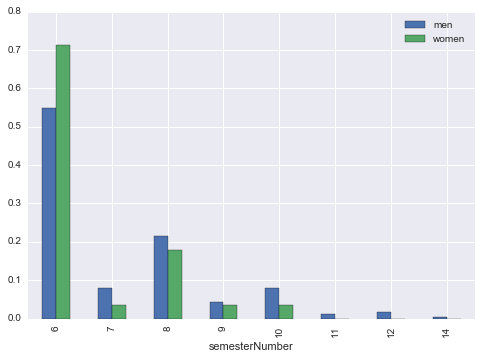

In [36]:
numberSemesters = startEndData[['gender', 'semesterNumber']]
# We group the number of semester by values, so we can count how many times each number occure.
numberSemestersPerLength = numberSemesters.groupby('semesterNumber')

totalNbMen = numberSemesters[numberSemesters.gender == 'Monsieur'].size
totalNbWomen = numberSemesters[numberSemesters.gender == 'Madame'].size

# Divide into men and women
numberSemestersPerLengthDivided = []
for lengthGroup in numberSemestersPerLength:
    length = lengthGroup[0]
    personsWithLength = lengthGroup[1]
    percentageMen = personsWithLength[personsWithLength.gender == 'Monsieur'].size / totalNbMen
    percentageWomen = personsWithLength[personsWithLength.gender == 'Madame'].size / totalNbWomen
    numberSemestersPerLengthDivided.append({'semesterNumber':length, 'men':percentageMen, 'women':percentageWomen})

# Plot the histogram
dfNumberSemesters = pd.DataFrame(numberSemestersPerLengthDivided)
dfNumberSemesters = dfNumberSemesters.set_index(['semesterNumber'])
dfNumberSemesters.plot.bar()
plt.show()

As we could expect, the major part of the students do their Bachelor in 6 semesters, i.e 3 years. But still more or less 30% redo at least one year. Let's also mention the student that took 7 years to do his Bachelor degree. He accomplished kind of a record! 

## TASK 2: Master students

In this second assigment, we will now analyze the master student. This part is more tricky, because the data are not well structure as Bachelor ones. Some students will finish their master in 2 semesters (if they don't do any minor or specialization). For students with a minor or a specialization, they will have to do at least 3 semester. Moreover, most of the 'Project Master' entries are empty (even if the student has probably done a project). Therefore, we haven't fetch this information from IS-Academia, because the information is not reliable.

In order to count the number of semesters done by the students to finish their master degree, we considered the following points:

A student has graduated if
- There is at least an entry for *'Master semestre 1'* and *'Master semestre 2'*
- If he has a minor or a specialization, there is at least an entry for *'Master semestre 3'*

If he has graduated, we count one semester at the end of his studies for the master project (instead of checking its entry in the data).

Let's start by uploading the data from the file.

In [37]:
data_ma = pd.read_csv('data_ma.csv', ',')
data_ma.shape

(2431, 10)

Then, we keep only the students with an entry in *'Master semestre 1'* and *'Master semestre 2'*.

In [38]:
# Sort people
data_ma.sort_values(ascending=[True, True, True], by=['sciper', 'year', 'semester'], inplace=True)

# Select only the people for which we have a 'Master semester 1' entry
sem1_scipers = data_ma[data_ma.semester == 'Master semestre 1'].sciper.drop_duplicates(keep='first')

# Select only the people for which we have a 'Master semester 2' entry
sem2_scipers = data_ma[data_ma.semester == 'Master semestre 2'].sciper.drop_duplicates(keep='first')

# Take the intersection of the two list of scipers above, students in master semester 1 and 2
correct_scipers = pd.Series(list(set(sem1_scipers).intersection(set(sem2_scipers)))).sort_values(ascending=True)

In [39]:
data_corrected_ma = data_ma[data_ma['sciper'].isin(correct_scipers)]
data_corrected_ma.head(5)

,gender,minor,name,sciper,specialization,status,section,year,semester,season
14,Monsieur,NaN,Cardinaux Damien,146330,NaN,Présent,Informatique,2007-2008,Master semestre 1,Semestre d'automne
87,Monsieur,NaN,Cardinaux Damien,146330,NaN,Présent,Informatique,2007-2008,Master semestre 2,Semestre de printemps
353,Monsieur,NaN,Cardinaux Damien,146330,NaN,Présent,Informatique,2008-2009,Master semestre 3,Semestre d'automne
257,Monsieur,NaN,Marx Clément,146742,"Signals, Images and Interfaces",Présent,Informatique,2008-2009,Master semestre 1,Semestre d'automne
321,Monsieur,NaN,Marx Clément,146742,"Signals, Images and Interfaces",Présent,Informatique,2008-2009,Master semestre 2,Semestre de printemps


We get the number of semesters for each student (identified by its sciper), counting the number of time a sciper appears in the list.

In [40]:
# Counting how many times each sciper appears in the list
semester_number_ma = data_corrected_ma.sciper.value_counts().to_frame()

semester_number_ma.reset_index(level = 0, inplace = True)
semester_number_ma.columns = ['sciper', 'semesterNumber']
semester_number_ma.head(5)

,sciper,semesterNumber
0,179988,7
1,166491,7
2,170530,6
3,181244,6
4,200932,6


We can now merge this new information in the previous table. We will also keep only one entry for each student with the year of his first master semester. We also noticed that a specialization or a minor of students was not appearing in all the semester entries of the same student. Therefore, if a specialization or a minor appeard once in the tabs, we kept it for the student.

In [41]:
data_students_ma = data_corrected_ma.drop_duplicates(subset=['sciper'], keep='first')
data_students_ma = pd.merge(data_students_ma[['gender', 'name', 'sciper', 'section', 'year']], semester_number_ma, how='inner', left_on='sciper', right_on='sciper')

data_special_ma = data_ma.dropna(subset = ['specialization']).drop_duplicates(subset=['sciper'], keep='last')
data_students_ma = pd.merge(data_students_ma, data_special_ma[['sciper', 'specialization']], how='left', left_on='sciper', right_on='sciper')

data_minor_ma = data_ma.dropna(subset = ['minor']).drop_duplicates(subset=['sciper'], keep='last')
data_students_ma = pd.merge(data_students_ma, data_minor_ma[['sciper', 'minor']], how='left', left_on='sciper', right_on='sciper')

data_students_ma.head(10)

,gender,name,sciper,section,year,semesterNumber,specialization,minor
0,Monsieur,Cardinaux Damien,146330,Informatique,2007-2008,3,NaN,NaN
1,Monsieur,Marx Clément,146742,Informatique,2008-2009,5,"Signals, Images and Interfaces",NaN
2,Monsieur,Junod Antoine,146929,Informatique,2007-2008,2,NaN,NaN
3,Monsieur,Good Xavier,147008,Informatique,2011-2012,4,"Signals, Images and Interfaces",NaN
4,Monsieur,Anagnostaras David,152232,Informatique,2007-2008,3,NaN,"Mineur en Management, technologie et entrepren..."
5,Monsieur,Aeberhard François-Xavier,153066,Informatique,2007-2008,6,Internet computing,NaN
6,Monsieur,Cassina Ilya,153746,Informatique,2007-2008,3,NaN,NaN
7,Monsieur,Conus Johann,153762,Informatique,2008-2009,4,NaN,NaN
8,Monsieur,Fomene Tierry Alain,154080,Informatique,2007-2008,5,Internet computing,NaN
9,Madame,Benabdallah Zeineb,154573,Informatique,2007-2008,5,Biocomputing,NaN


We can check now if all the students with a minor or a specialization have done at least 3 semesters. If not, we consider that they don't have finished their degree.

In [42]:
# Finding the sciper of the student that have not finish their degree
wrong_sciper_specialization_ma = data_students_ma[data_students_ma.semesterNumber == 2].dropna(subset = ['specialization']).sciper
wrong_sciper_minor_ma = data_students_ma[data_students_ma.semesterNumber == 2].dropna(subset = ['minor']).sciper

# We take out these students from our DataFrame
data_students_ma = data_students_ma[~data_students_ma['sciper'].isin(wrong_sciper_specialization_ma)]
data_students_ma = data_students_ma[~data_students_ma['sciper'].isin(wrong_sciper_minor_ma)]
data_students_ma.shape

(697, 8)

Now that we consider that every students in our tabs has finished his degree, we can start analyzing the data.

First, we need to add one more semester for each student for counting their master project.

In [43]:
data_final_students_ma = data_students_ma.copy()
data_final_students_ma.semesterNumber = data_final_students_ma.semesterNumber + 1

Now we can plot the histogram of the mean number of semester done by the students depending on their specialization. If a student does not have any specialization, we note *'No specialization'*.

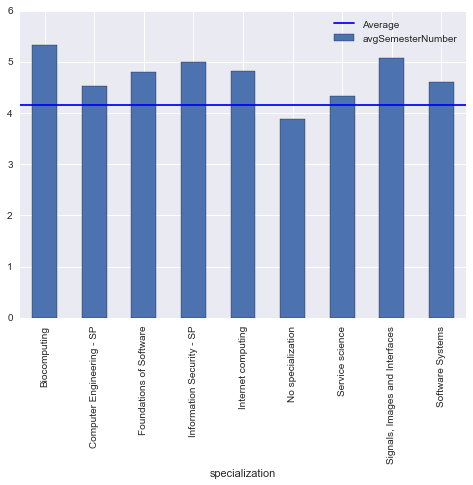

In [44]:
# Replacing specialization values NaN by 'No specialization'
data_students_ma_with_specialization = data_final_students_ma.copy()
data_students_ma_with_specialization.specialization.fillna(value = 'No specialization', inplace = True)

# Group by specialization
numberSemesters = data_students_ma_with_specialization[['specialization', 'semesterNumber']]
numberSemestersPerSpecialization = numberSemesters.groupby('specialization')

# Dividing the DataFrame into different specialization and storing the average for each one
numberSemestersPerSpecializationDivided = []
lengthsPerSpecialization = {}
for specializationGroup in numberSemestersPerSpecialization:
    specialization = specializationGroup[0]
    personsWithLength = specializationGroup[1]
    
    avgLength = np.round_(personsWithLength['semesterNumber'].mean(),decimals=3)
    numberSemestersPerSpecializationDivided.append({'avgSemesterNumber':avgLength, 
                                                    'specialization': specialization})
    
    lengthsPerSpecialization[specialization] = personsWithLength['semesterNumber']
    

avgLengthPerSpecialization = pd.DataFrame(numberSemestersPerSpecializationDivided)
avgLengthPerSpecialization = avgLengthPerSpecialization.set_index(['specialization'])
ax = avgLengthPerSpecialization.plot.bar()

# Computing overall average
generalAvg = data_students_ma_with_specialization.semesterNumber.mean()

# Plotting the results
plt.axhline(y=generalAvg, color='b', label='Average')
plt.legend()
plt.show()

Note that the mean of the student without specialization is the only one below 4 semesters. 

To conclude which values is statistically significant, we use the same website for the statistics reference and do a one-sample t-test.
Here is the explanation: "A one-sample t-test checks whether a sample mean differs from the population mean."

In [45]:
# Import stats library
import scipy.stats as stats

table = []
pvalue_level = 0.05
for specialization in lengthsPerSpecialization:
    lengths = lengthsPerSpecialization[specialization]

    resStat = stats.ttest_1samp(a= lengths.values, popmean= generalAvg)
    pvalue = resStat.pvalue
    
    table.append({'Specialization':specialization, '# students':lengths.size, 
                  'p-value': pvalue, 'Differs significantly': 'Yes' if pvalue < pvalue_level else 'No'})
    
df = pd.DataFrame(table)
df = df.set_index(['Specialization'])
df

,# students,Differs significantly,p-value
Specialization,,,
Computer Engineering - SP,17,Yes,8.263090e-03
No specialization,500,Yes,2.339821e-10
Software Systems,10,Yes,2.306731e-02
Biocomputing,3,No,2.187936e-01
Foundations of Software,56,Yes,1.981885e-07
Internet computing,82,Yes,3.255559e-09
"Signals, Images and Interfaces",24,Yes,1.723649e-04
Service science,3,No,6.435969e-01
Information Security - SP,2,Yes,0.000000e+00


We can observe for which specialization its differs significantly, i.e which one has a p-value smaller than 0.05.

# BONUS TASK: Master students by gender

For this last part, we will now compare Master duration depeding on the gender of the students. Let's see if women are still smarter than men in the master degree.

The 'year' column in *data_final_students_ma* corresponds to the starting year of the degree, i.e the year of *'Master semestre 1'*.

In [54]:
data_final_students_ma.head(5)

,gender,name,sciper,section,year,semesterNumber,specialization,minor
0,Monsieur,Cardinaux Damien,146330,Informatique,2007-2008,4,NaN,NaN
1,Monsieur,Marx Clément,146742,Informatique,2008-2009,6,"Signals, Images and Interfaces",NaN
2,Monsieur,Junod Antoine,146929,Informatique,2007-2008,3,NaN,NaN
3,Monsieur,Good Xavier,147008,Informatique,2011-2012,5,"Signals, Images and Interfaces",NaN
4,Monsieur,Anagnostaras David,152232,Informatique,2007-2008,4,NaN,"Mineur en Management, technologie et entrepren..."


We repeat the same analysis as before in the Task 1.

In [55]:
# Separating men and women
dataMen = data_final_students_ma[data_final_students_ma.gender == 'Monsieur']
dataWomen = data_final_students_ma[data_final_students_ma.gender == 'Madame']

numberSemestersMen = dataMen['semesterNumber']
numberSemestersWomen = dataWomen['semesterNumber']

# Computing the mean duration
meanMen = numberSemestersMen.mean()
meanWomen = numberSemestersWomen.mean()
print(meanMen)
print(meanWomen)

4.1547420965058235
4.145833333333333


This time, we observe that the mean duration is almost the same for men and women! Let's check if the stats give us the same conclusion.

In [56]:
import scipy.stats as stats

stats.ttest_ind(a= numberSemestersMen,
                b= numberSemestersWomen,
                equal_var=False)    # Assume samples have equal variance?

Ttest_indResult(statistic=0.078291611584163603, pvalue=0.93772412598508392)

Because the p-value is 0.938 (much bigger than 0.05), the difference in study lengths at master level is not statistically significant. The statistical approach give us the same conclusion!

We can now plot an histogram of the duration for each group: Men and Women

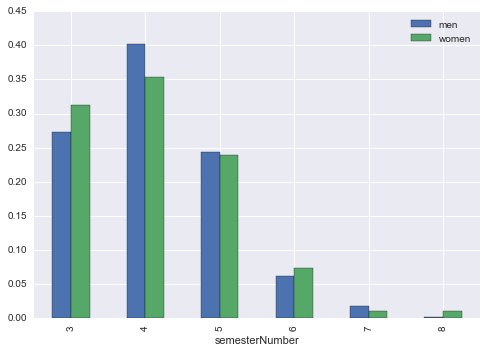

In [57]:
numberSemesters = data_final_students_ma[['gender', 'semesterNumber']]
numberSemestersPerLength = numberSemesters.groupby('semesterNumber')

totalNbMen = numberSemesters[numberSemesters.gender == 'Monsieur'].size
totalNbWomen = numberSemesters[numberSemesters.gender == 'Madame'].size

# Dividing into men and women
numberSemestersPerLengthDivided = []
for lengthGroup in numberSemestersPerLength:
    length = lengthGroup[0]
    personsWithLength = lengthGroup[1]
    percentageMen = personsWithLength[personsWithLength.gender == 'Monsieur'].size / totalNbMen
    percentageWomen = personsWithLength[personsWithLength.gender == 'Madame'].size / totalNbWomen
    numberSemestersPerLengthDivided.append({'semesterNumber':length, 'men':percentageMen, 'women':percentageWomen})
    
dfNumberSemesters = pd.DataFrame(numberSemestersPerLengthDivided)
dfNumberSemesters = dfNumberSemesters.set_index(['semesterNumber'])

# Plot
dfNumberSemesters.plot.bar()
plt.show()

It can be interesting to also observe the mean duration of the master degree depending on the student starting year!

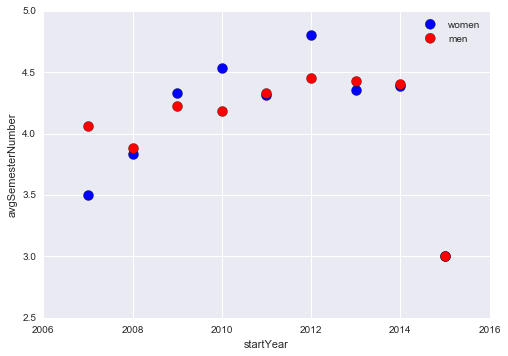

In [58]:
numberSemesters = data_final_students_ma[['year', 'gender', 'semesterNumber']]
numberSemestersPerYearAndGender = numberSemesters.groupby(['year', 'gender'])

# Function to extract the starting year
extract_year = lambda year: int(year.split('-')[0])

# Dividing between men and women
avgSemestersPerStartYearMen = []
avgSemestersPerStartYearWomen = []
for lengthGroup in numberSemestersPerYearAndGender:
    yearStr, gender = lengthGroup[0]
    startYear = extract_year(yearStr)
    lengthsDf = lengthGroup[1]
    semesterNumbersDistribution = lengthGroup[1].semesterNumber
    if gender == 'Monsieur':
        avgSemestersPerStartYearMen.append({'avgSemesterNumber':semesterNumbersDistribution.mean(), 
                                            'startYear': startYear})
    elif gender == 'Madame':
        avgSemestersPerStartYearWomen.append({'avgSemesterNumber':semesterNumbersDistribution.mean(), 
                                              'startYear': startYear})

dfNumberSemestersWomen = pd.DataFrame(avgSemestersPerStartYearWomen)
dfNumberSemestersMen = pd.DataFrame(avgSemestersPerStartYearMen)

dfNumberSemestersWomen = dfNumberSemestersWomen.reindex()
dfNumberSemestersMen = dfNumberSemestersMen.reindex()

# Plot
ax1 = dfNumberSemestersWomen.plot.scatter(x='startYear', y='avgSemesterNumber', s=100, color='b', label='women')
dfNumberSemestersMen.plot.scatter(x='startYear', y='avgSemesterNumber', s=100, ax=ax1, color='r',label='men')
plt.legend()
plt.show()


The graph obtained above is interesting but it does not give us much information, because we don't know how many students are included in this graph per year. Therefore, it would be more intuitive to plot the duration for every student.

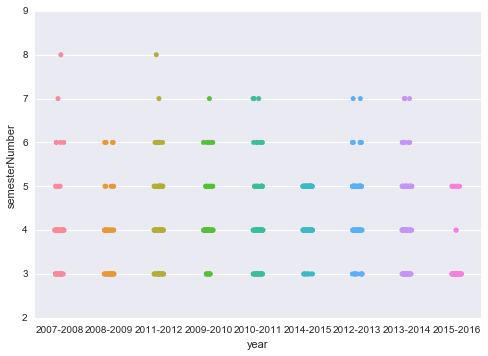

In [61]:
numberSemestersWomen = numberSemesters[numberSemesters.gender == 'Madame']
numberSemestersMen = numberSemesters[numberSemesters.gender == 'Monsieur']

# Function to extract the starting year
extract_year = lambda year: int(year.split('-')[0])

numberSemestersWomen['year'].apply(extract_year)
numberSemestersMen['year'].apply(extract_year)

# Plot
ax1 = sns.stripplot(x='year', y='semesterNumber', data=numberSemestersWomen, jitter=True, s=5, label='women')
sns.stripplot(x='year', y='semesterNumber', data=numberSemestersMen, jitter=True, s=5, label='men', ax=ax1)
plt.show()

It is better, but because of the big number of data, it is hard to see all the points on the graph.
Let's try yet another way to visualize the data, now emphasizing the distribution of study length.

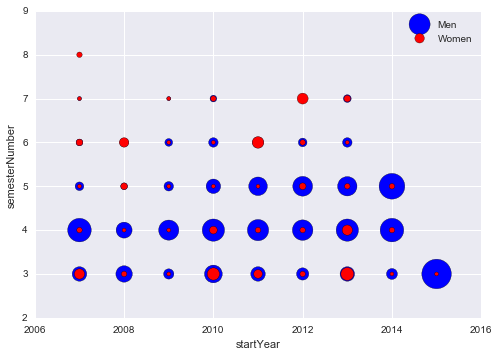

In [62]:
numberSemesters = data_final_students_ma[['year', 'gender', 'semesterNumber']]
numberSemestersPerYearGenderTime = numberSemesters.groupby(['year', 'gender', 'semesterNumber'])

numberMenPerYearLength = []
numberWomenPerYearLength = []
for lengthGroup in numberSemestersPerYearGenderTime:
    yearStr, gender, semesterNumber = lengthGroup[0]
    startYear = extract_year(yearStr)
    
    # Getting the number of students with this length
    numberStudents = lengthGroup[1].size
    if gender == 'Monsieur':
        numberMenPerYearLength.append({'semesterNumber':semesterNumber, 
                                       'startYear': startYear, 'count':numberStudents})
    elif gender == 'Madame':
        numberWomenPerYearLength.append({'semesterNumber':semesterNumber, 
                                       'startYear': startYear, 'count':numberStudents})


dfCountsSemestersWomen = pd.DataFrame(numberWomenPerYearLength)
dfCountsSemestersMen = pd.DataFrame(numberMenPerYearLength)

# Plot
ax1 = dfCountsSemestersMen.plot.scatter(x='startYear', y='semesterNumber', 
                                  label='Men', s=dfCountsSemestersMen['count']*5, color='b')

dfCountsSemestersMen.plot.scatter(x='startYear', y='semesterNumber', 
                                  label='Women', s=dfCountsSemestersWomen['count']*5, color='r', ax=ax1)
plt.show()

Much better! Now we can see clearly how much time students take to finish their Master degree. 

Note also that the big number of students starting their degree in 2015 and finishing in 3 semesters is maybe due to the fact that many of them did not choose any specialization yet, but they will probably not do their master in 1 year. Unfortunatly, we don't have enough information in our data to distinguish these students to the other ones. One solution would have been to check if they are enroll for another semester in *'2016-2017'*.